Individual Planning Report

(1) Data Description:

We have two datasets:

players.csv (196 observations, 7 variables):

- experience (Pro, Veteran, Regular, Amateur): Categorical variable of skill level
- subscribe (True/False): whether a player is subscribed to the newsletter
- hashedEmail (string): Unique player identifier (hashed)
- played_hours (float): Total hours played, ranging from 0.0 to ~ 223.1
- name (string): Player’s name 
- gender (Male/Female): Player’s gender
- Age: Player’s age

sessions.csv (1535 observations, 5 variables):

- hashedEmail (string): Key matching players.csv (hashed)
- start_time & end_time (string, dd/mm/yyyy HH:MM): Human-readable session start/end timestamps
- original_start_time & original_end_time (float, Unix epoch ms): Same as above but numeric

Potential data issues include missing age entries, session end times, and possible mismatch between played_hours in players.csv and session-level durations (ex: if data were recorded differently). Because name and hashedEmail are separate identifiers, name may not be unique. The sessions data uses hashedEmail to link to players, so if we want session-level behavioral summaries, we’ll need to parse times or subtract original_start_time from original_end_time

(2) Questions:

Broad question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Specific Question: Can we predict newsletter subscription (subscribe) from demographic (Age, gender) and behavioral variables (played_hours, total session counts/durations), and do these factors vary by experience group?

(3) Exploratory Data Analysis and Visualization

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
players <- read.csv("players.csv")
sessions <- read.csv("sessions.csv")
head(players)
head(sessions)


,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


,hashedEmail,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
6,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [3]:
player_summary <- players |>
    summarise(mean_played_hours = mean(played_hours, na.rm=TRUE), mean_age = mean(Age, na.rm=TRUE))
player_summary

mean_played_hours,mean_age
<dbl>,<dbl>
5.845918,20.52062


In [4]:
library(lubridate)

sessions_tidy <- sessions |>
  mutate(
    start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"),
    end_time   = as.POSIXct(end_time,   format = "%d/%m/%Y %H:%M"),
    
    start_day   = day(start_time),
    start_month = month(start_time),
    start_year  = year(start_time),
    start_hour  = hour(start_time),
    start_min   = minute(start_time),
    
    end_day   = day(end_time),
    end_month = month(end_time),
    end_year  = year(end_time),
    end_hour  = hour(end_time),
    end_min   = minute(end_time)
  ) |>
  select(
    hashedEmail,
    original_start_time,
    original_end_time,
    start_day, start_month, start_year, start_hour, start_min,
    end_day, end_month, end_year, end_hour, end_min
  )

head(sessions_tidy)

,hashedEmail,original_start_time,original_end_time,start_day,start_month,start_year,start_hour,start_min,end_day,end_month,end_year,end_hour,end_min
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,1.71977e+12,1.71977e+12,30,6,2024,18,12,30,6,2024,18,24
2,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,1.71867e+12,1.71867e+12,17,6,2024,23,33,17,6,2024,23,46
3,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,1.72193e+12,1.72193e+12,25,7,2024,17,34,25,7,2024,17,57
4,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,1.72188e+12,1.72188e+12,25,7,2024,3,22,25,7,2024,3,58
5,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,1.71665e+12,1.71665e+12,25,5,2024,16,1,25,5,2024,16,12
6,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,1.71916e+12,1.71916e+12,23,6,2024,15,8,23,6,2024,17,10


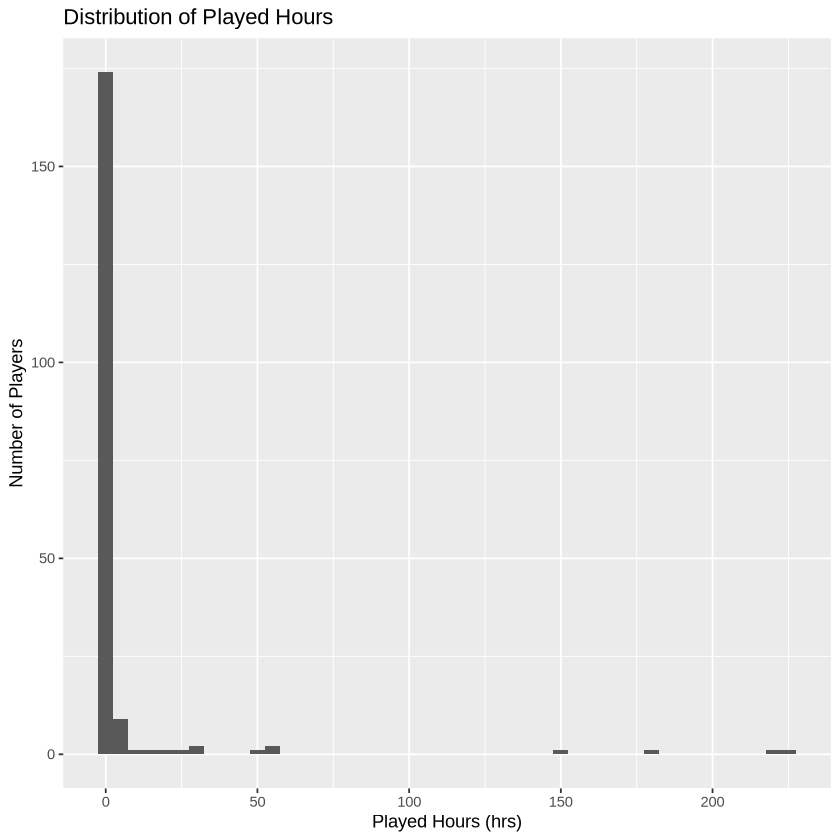

In [5]:
ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5) +
  labs(
    title = "Distribution of Played Hours",
    x = "Played Hours (hrs)",
    y = "Number of Players"
  )

This histogram reveals how many players fall into each range of total played hours. The data show most players in the lower range, it might suggest a short-term, casual user base and a long tail of high-hour players indicate a smaller subgroup of highly engaged players.

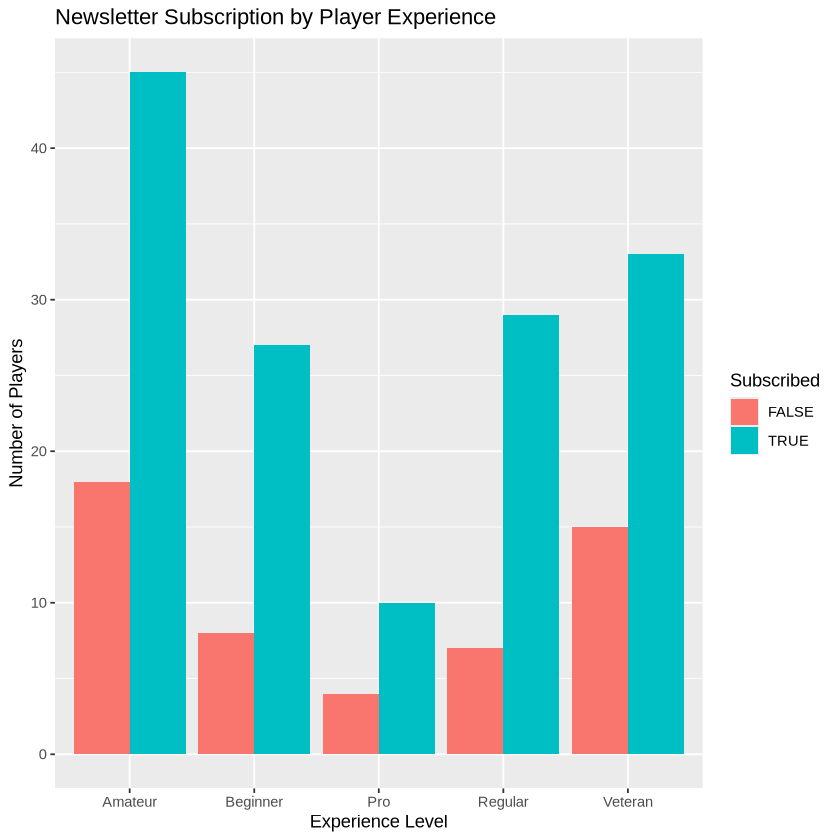

In [6]:
ggplot(players, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Newsletter Subscription by Player Experience",
    x = "Experience Level",
    y = "Number of Players",
    fill = "Subscribed"
  )

Placing subscription status side by side for each experience category helps see whether more experienced players are more likely to subscribe than less experienced players. I observe that amateur and beginner have more subscription than pro and veteran. The reason might be because they are trying to get into the game and follow esports or guides.

(4) Methods and Plan

Proposed Method: K-Nearest Neighbors (knn)
Why is this method appropriate?:
- Our outcome (newsletter subscription) is boolean (subscribe or not)
- knn classifies a new observation by looking at the classes of its nearest neighbors in the predictor space (ex: age, played hours, etc.)
- knn does not require strong assumptions about a linear relationship between predictors and the outcome
- it’s simple to implement once we’ve decided on a distance metric and the number of neighbors k

What assumptions does knn have?:
- Similar examples are physically close in the predictor space (ex: players with similar behaviors are likely to share subscription status)
- Requires that numeric variables be on a comparable scale so no one variable dominates the distance calculation. We will standardizing our variables
- Each predictor should be meaningful and relevant for distance-based classification

Potential limitations:
- Unlike linear models, knn doesn’t provide a direct formula or coefficients that show how each predictor affects the outcome
- Predicting new data can be slow for large datasets, because you must compute distances to every training point
- Sensitive to irrelevant features and different scales – so data cleaning and standardizing is important

How to compare and select the model:
- We will split the data into a training set and a test set (ex: 70%/30%) to avoid evaluating the model on the same data we used to train
- On the training set, we may use cross-validation to find a good number of neighbors k. Ex: test k=1,k=3,k=5,... and pick the best based on accuracy or other metrics.
- After choosing k, we finalize the model and evaluate it on the test set

How we’ll process the data:
- missing values: We may remove players lacking critical info (e.g., age) or impute missing data
- Scale numeric variables to have comparable ranges/variances, so that distance calculations aren’t skewed by one very large variable.